In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import scanpy as sc
import warnings
import threadpoolctl
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from custom_functions import filter_cv_vs_mean, scatter_viz, map_on_embedding, softmax

In [3]:
# Basic settings
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=True)

warnings.filterwarnings('ignore', category=DeprecationWarning)

threadpoolctl.threadpool_limits(limits=8)

matplotlib.style.use("default")
plt.rcParams['pdf.fonttype'] = 42

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.4.1 pandas==0.23.4 scikit-learn==0.22 statsmodels==0.10.1 python-igraph==0.7.1


In [4]:
# Load the data
control_1 = sc.read_h5ad("anndata_files/control_1.h5ad")
control_2 = sc.read_h5ad("anndata_files/control_2.h5ad")
treatment_1 = sc.read_h5ad("anndata_files/treatment_1.h5ad")
treatment_2 = sc.read_h5ad("anndata_files/treatment_2.h5ad")
plenti_1 = sc.read_h5ad("anndata_files/plenti_1.h5ad")
plenti_2 = sc.read_h5ad("anndata_files/plenti_2.h5ad")
b3gal_1 = sc.read_h5ad("anndata_files/b3gal_1.h5ad")
st3gal_1 = sc.read_h5ad("anndata_files/st3gal_1.h5ad")
st3gal_2 = sc.read_h5ad("anndata_files/st3gal_2.h5ad")

In [5]:
#Make sure the features are the same and remove nuisance genes
mitocondrial_genes = [i for i in control_1.var_names if i.startswith("MT-")]
rp_clone = [i for i in control_1.var_names if (i.startswith("RP") and "." in i)]
ac_putative = [i for i in control_1.var_names if (i.startswith("AC") and "." in i)]
super_highly_expressed = ['FTH1', 'FTL', 'MALAT1']

genes_selected = np.intersect1d(control_1.var.index, plenti_1.var.index)
genes_selected = np.setdiff1d(genes_selected, mitocondrial_genes + rp_clone + ac_putative+super_highly_expressed)

In [6]:
# Reduce the dataframes to the shared geneset
control_1 = control_1[:, genes_selected].copy()
treatment_1 = treatment_1[:, genes_selected].copy()
control_2 = control_2[:, genes_selected].copy()
treatment_2 = treatment_2[:, genes_selected].copy()

plenti_1 = plenti_1[:, genes_selected].copy()
b3gal_1 = b3gal_1[:, genes_selected].copy()
st3gal_1 = st3gal_1[:, genes_selected].copy()
plenti_2 = plenti_2[:, genes_selected].copy()
st3gal_2 = st3gal_2[:, genes_selected].copy()

In [7]:
# Load metadata, inclduing clustering
dump = np.load("saved_variables.npz")
ids = dump["ids"]
louvain = dump["louvain"]
batches = dump["batches"]
umps = dump["umps"]
ids_to_ump = dict(zip(ids,umps))
ids_to_louvain = dict(zip(ids,louvain))
ids_to_batches = dict(zip(ids,batches))

In [8]:
# Data cleanup

In [9]:
ref_list = [control_1, control_2, treatment_1, treatment_2]

for i in range(len(ref_list)):
    ref_list[i] = ref_list[i][np.in1d(ref_list[i].obs.index, ids), :]
    print(ref_list[i].shape)
    ref_list[i].obs["umap_1"] = np.stack([ids_to_ump[c] for c in ref_list[i].obs.index])[:,0]
    ref_list[i].obs["umap_2"] = np.stack([ids_to_ump[c] for c in ref_list[i].obs.index])[:,1]
    ref_list[i].obs["cluster"] = np.stack([ids_to_louvain[c] for c in ref_list[i].obs.index])

Trying to set attribute `.obs` of view, making a copy.


(2404, 19860)


Trying to set attribute `.obs` of view, making a copy.


(3177, 19860)


Trying to set attribute `.obs` of view, making a copy.


(2977, 19860)


Trying to set attribute `.obs` of view, making a copy.


(3450, 19860)


In [10]:
list_ad = [plenti_1, b3gal_1,st3gal_1,plenti_2,st3gal_2]
all_samples = ref_list + list_ad

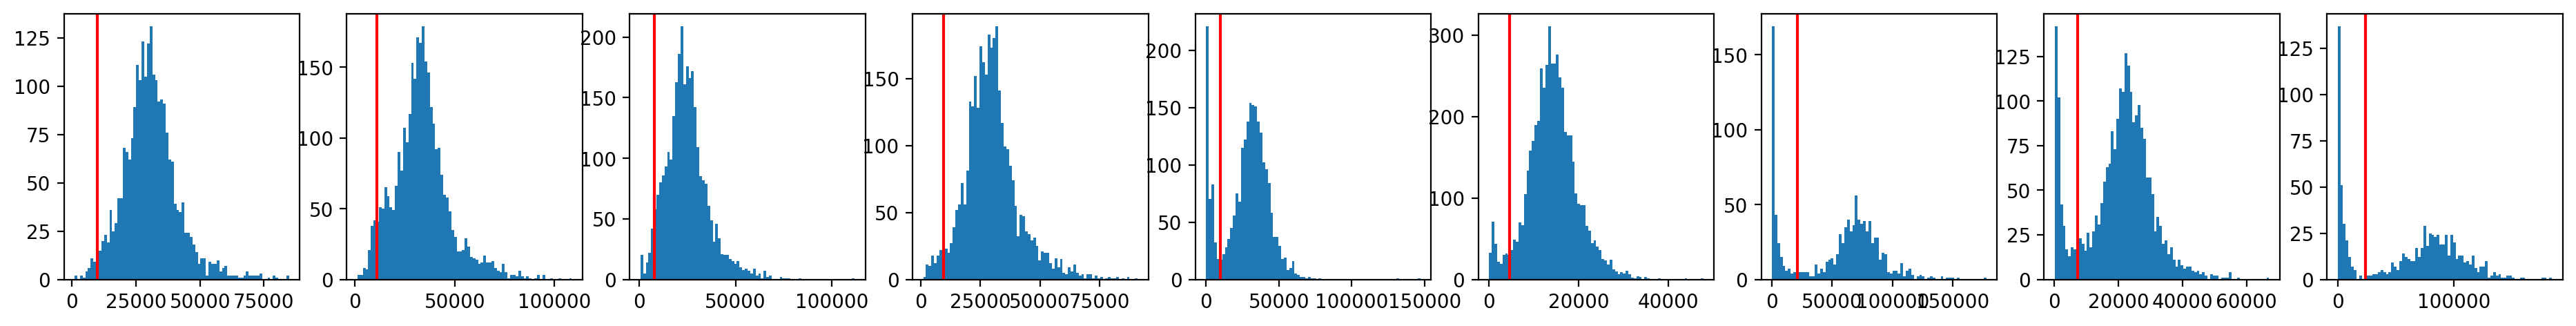

In [11]:
plt.figure(None, (26,2.5))
for i, ann in enumerate(all_samples):
    plt.subplot(1,10,i+1)
    plt.hist(ann.X.sum(1).A.flatten(), bins=80);
    plt.axvline(np.median(ann.X.sum(1).A.flatten())*0.33, c="r")

In [12]:
# Al samples are cleaned up by removing the cells with total counts smallen than 33% ot the median
for ann in all_samples:
    sc.pp.filter_cells(ann, min_counts=np.median(ann.X.sum(1).A.flatten())*0.33)

filtered out 41 cells that haveless than 9968.475 counts
filtered out 125 cells that haveless than 10799.91 counts
filtered out 109 cells that haveless than 7822.9800000000005 counts
filtered out 100 cells that haveless than 9572.310000000001 counts
filtered out 431 cells that haveless than 9984.810000000001 counts
filtered out 274 cells that haveless than 4641.285 counts
filtered out 285 cells that haveless than 21109.11 counts
filtered out 386 cells that haveless than 7161.0 counts
filtered out 266 cells that haveless than 23674.695 counts


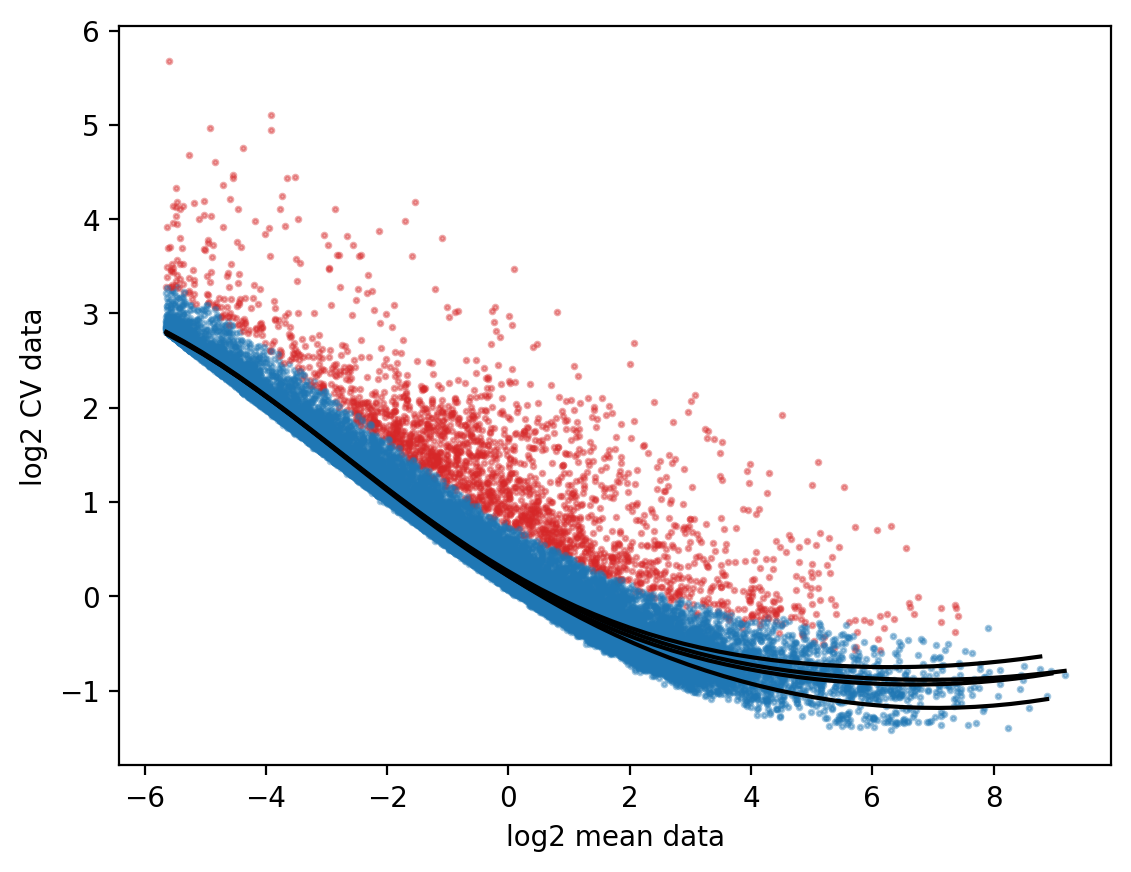

In [13]:
# Feature selection is performed on the Control-Treatment sample
# Note that we do the procedure on each batch independently and an union operation is performed downstream
selected_list = []
for ann in [control_1,control_2,treatment_1,treatment_2]:
    cv_mean_selected, _ = filter_cv_vs_mean(ann.X.A.T, 500, plot=True, svr_gamma=0.02,
                                                    min_nonzero_cells=10, min_feat_avg=0.02, max_feat_avg=600)
    selected_list.append(cv_mean_selected)

selected_genes = ann.var.index[np.sum(selected_list,0) > 1]

In [14]:
# Downsample molecules to match median but mantain relative difference in depth between different cells
medians = []
for ann in all_samples:
    medians.append(np.median(ann.X.sum(1).A.flatten()))
downsapling_factor = np.min(medians) / np.array(medians)

for ann, downfact in zip(all_samples, downsapling_factor):
    sc.pp.downsample_counts(ann, (ann.X.sum(1).A.flatten() * downfact).astype(int))

In [15]:
# Downsample all the reference samples to the same number of cells
for ann in all_samples:
    ann.X = ann.X.astype(float)
    
np.random.seed(19900715)
for i in range(len(list_ad)):
    if list_ad[i].shape[0] > 800:
        list_ad[i] = list_ad[i][np.random.choice(list_ad[i].shape[0], size=800, replace=False) ,:]

In [16]:
all_samples = ref_list + list_ad

In [17]:
for ann in all_samples:
    sc.pp.normalize_total(ann, target_sum=15000.)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


In [18]:
selected_genes = selected_genes.union(["B3GALNT1", "ST3GAL5"])

In [19]:
all_samples_feat_sel = []
for ann in all_samples:
    all_samples_feat_sel.append(ann[:, selected_genes])

In [20]:
all_samples_log = []
for ann in all_samples_feat_sel:
    all_samples_log.append(sc.pp.log1p(ann, copy=True))

In [21]:
control_1_log, control_2_log, treatment_1_log, treatment_2_log = all_samples_log[:4]
plenti_1_log, b3gal_1_log, st3gal_1_log, plenti_2_log, st3gal_2_log = all_samples_log[4:]

reference_concat = control_1_log.concatenate(control_2_log, treatment_1_log, treatment_2_log,
                                             batch_categories=["control_1", "control_2", "treatment_1", "treatment_2"],
                                             index_unique=None)

probe_concat = plenti_1_log.concatenate(b3gal_1_log, st3gal_1_log, plenti_2_log, st3gal_2_log,
                                        control_1_log.concatenate(control_2_log), treatment_1_log.concatenate(treatment_2_log),
                                         batch_categories=["plenti_1", "b3gal_1", "st3gal_1", "plenti_2", "st3gal_2",
                                                           "validation_ctrl","validation_treat"])

In [22]:
reference_concat.obsm["umap"] = np.stack([reference_concat.obs["umap_1"], reference_concat.obs["umap_2"]]).T

In [23]:
downsampleB = np.random.choice(reference_concat.shape[0], 10000, replace=False)

mappings, ixR, R = map_on_embedding(probe_concat.X.A, reference_concat[downsampleB,:].X.A,
                                    embedding = reference_concat[downsampleB, :].obsm["umap"],
                                    k_neighbours=20)

ixR = np.argsort(R, 1)[:, :25]

topRs = R[np.arange(R.shape[0])[:, None], ixR]
weights = softmax(-topRs, alpha=20)

In [24]:
umap = np.array(reference_concat[downsampleB, :].obsm["umap"])

In [25]:
probe_concat.obsm["umap"] = np.sum(umap[ixR, :] * weights[:,:,None], 1)

In [26]:
uq_batches = np.unique(probe_concat.obs["batch"])

In [27]:
kde = KernelDensity(bandwidth=0.35)
log_density_dict = {}
for batch in uq_batches:
    log_density_dict[batch] = kde.fit(probe_concat.obsm["umap"][probe_concat.obs["batch"] == batch, :]).score_samples(reference_concat.obsm["umap"])

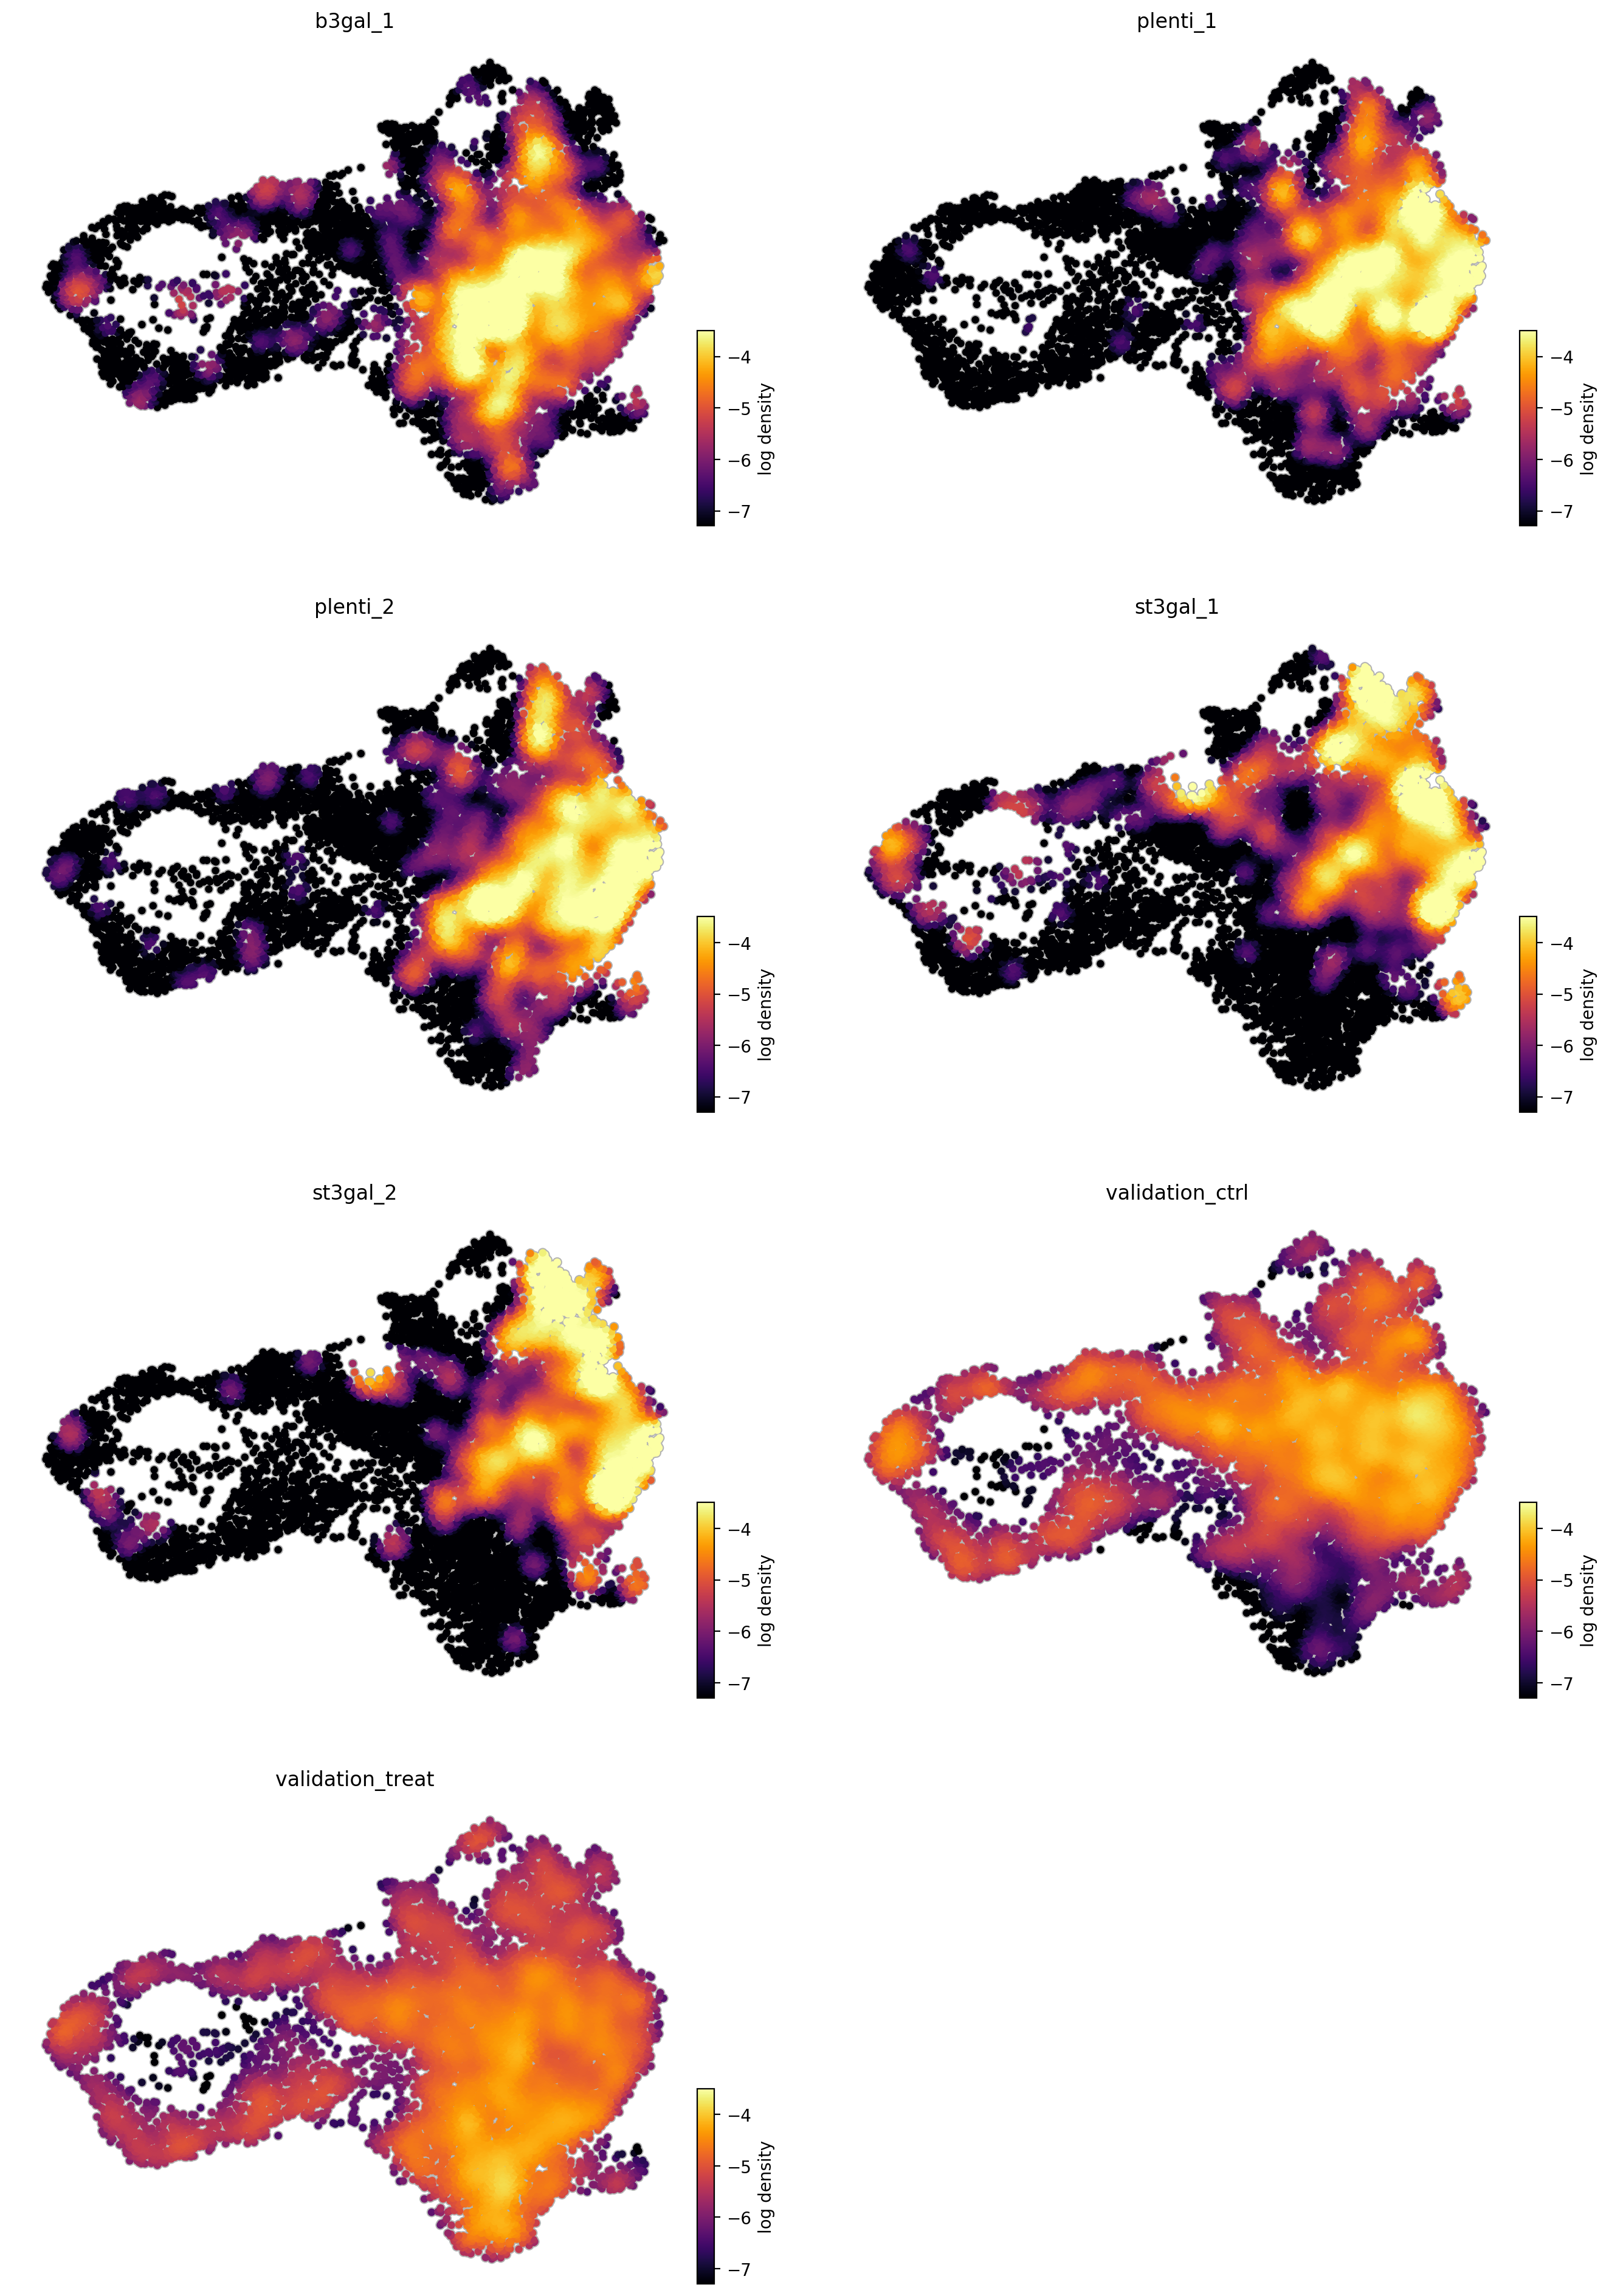

In [28]:
log_density_ref = kde.fit(reference_concat.obsm["umap"]).score_samples(reference_concat.obsm["umap"])
kwargs_dict = dict(s=20, cmap="inferno", vmin=np.percentile(log_density_ref,1.)-0.75, vmax=np.percentile(log_density_ref,99.)+0.75, ec="none",
                   rasterized=True)

fig = plt.figure(None, (16,24))
gs = plt.GridSpec(4,2)
for i, batch in enumerate(uq_batches):
    plt.subplot(gs[i])
    scatter_viz(reference_concat.obsm["umap"][:, 0], reference_concat.obsm["umap"][:, 1], c="0.7",  s=35, ec="none",  rasterized=True)
    scatter_viz(reference_concat.obsm["umap"][:, 0], reference_concat.obsm["umap"][:, 1], c=log_density_dict[batch], **kwargs_dict)
    plt.axis("off")
    plt.title(batch)
    axins = inset_axes(plt.gca(), width="2.5%",height="40%",loc='lower right', bbox_to_anchor=(0.025, 0., 1, 1),
                       bbox_transform=plt.gca().transAxes, borderpad=0,)
    plt.colorbar(cax=axins)
    plt.ylabel("log density")